# Autotalker Tutorial

Created by Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import argparse
import os
from datetime import datetime

import matplotlib
import mlflow
import numpy as np
import scanpy as sc
import squidpy as sq
import torch
from matplotlib.pyplot import rc_context

from autotalker.benchmarking import (compute_avg_cad_metric,
                                     compute_min_lnmi_metric)
from autotalker.data import load_spatial_adata_from_csv
from autotalker.models import Autotalker
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions)

In [3]:
# Define default matplotlib figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)

# 1.2 Configure Paths and Create Directories

In [4]:
# Mlflow
os.makedirs("mlruns", exist_ok=True)

# Gene program data
gp_data_folder_path = "datasets/gp_data"
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"
os.makedirs(gp_data_folder_path, exist_ok=True)

### 1.3 Define Parameters

In [5]:
random_state = 42
dataset = "squidpy_seqfish"
radius = 0.05 # 30.0 for slideseqv2
# node_label_method = "self"
# node_label_method = "one-hop-sum"
node_label_method = "one-hop-norm"
# node_label_method = "one-hop-attention"
n_latent_fc_gps = 512
edge_batch_size = 32 # training did not work when too small

## 2. Load Data

In [6]:
print(f"Using dataset {dataset}.")

if dataset == "deeplinc_seqfish":
    adata = load_spatial_adata_from_csv(counts_file_path="datasets/seqFISH/counts.csv",
                                        adj_file_path="datasets/seqFISH/adj.csv",
                                        cell_type_file_path="datasets/seqFISH/cell_types.csv",
                                        cell_type_col="Cell_class_name")
    cell_type_key = "cell_type"
elif dataset == "squidpy_seqfish":
    adata = sq.datasets.seqfish()
    sq.gr.spatial_neighbors(adata, radius=radius, coord_type="generic")
    cell_type_key = "celltype_mapped_refined"
elif dataset == "squidpy_slideseqv2":
    adata = sq.datasets.slideseqv2()
    sq.gr.spatial_neighbors(adata, radius=radius, coord_type="generic")
    cell_type_key = "cluster"
    
adata.layers["counts"] = adata.X.copy()

Using dataset squidpy_seqfish.


In [7]:
print(f"Number of nodes: {adata.layers['counts'].shape[0]}")
print(f"Number of node features: {adata.layers['counts'].shape[1]}")
avg_edges_per_node = round(
    adata.obsp['spatial_connectivities'].toarray().sum(axis=0).mean(),2)
print(f"Average number of edges per node: {avg_edges_per_node}")
n_edges = int(np.triu(adata.obsp['spatial_connectivities'].toarray()).sum())
print(f"Number of edges: {n_edges}", sep="")

Number of nodes: 19416
Number of node features: 351
Average number of edges per node: 7.66
Number of edges: 74329


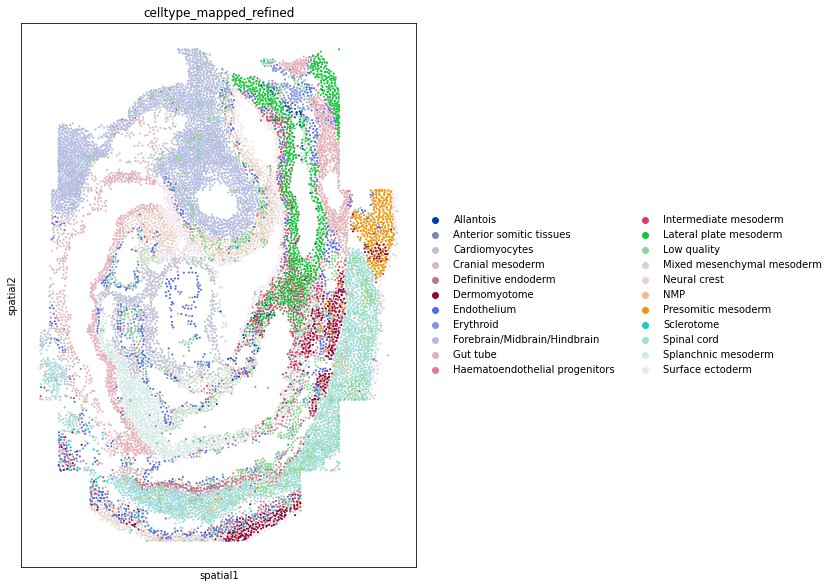

In [8]:
# Plot spatial data colored by cell types
sc.pl.spatial(adata, color="celltype_mapped_refined", spot_size=0.03)

KeyboardInterrupt: 

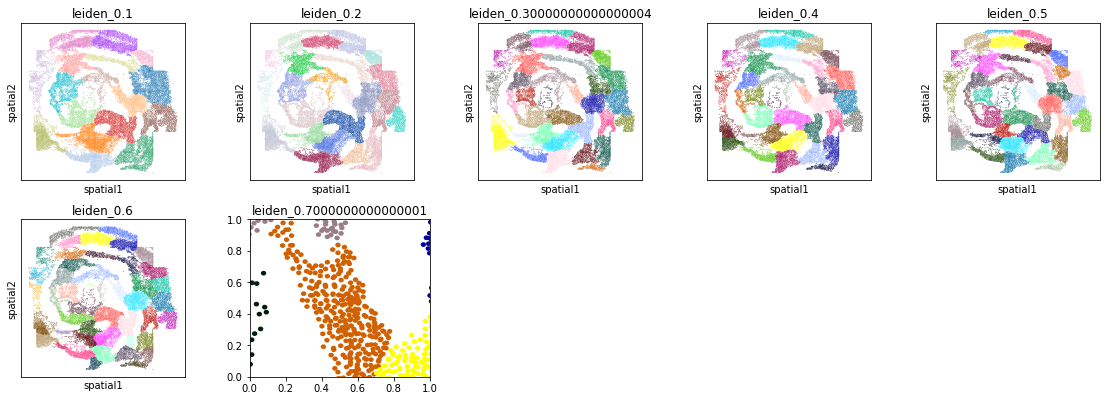

In [9]:
# Calculate adjacency matrix for Leiden clustering
sq.gr.spatial_neighbors(adata,
                        spatial_key="spatial",
                        coord_type="generic",
                        key_added="leiden",
                        n_neighs=6)

# Calculate Leiden clustering
clustering_resolutions = np.linspace(0.1, 1.0, 10)
for resolution in clustering_resolutions:
    sc.tl.leiden(adata,
                 resolution=resolution,
                 random_state=random_state,
                 key_added=f"leiden_{resolution}",
                 adjacency=adata.obsp["leiden_connectivities"])

# Plot Leiden clustering
with rc_context({"figure.figsize": (3, 3)}):
    sc.pl.spatial(adata,
                  color=[f"leiden_{resolution}" for resolution in clustering_resolutions],
                  ncols=5,
                  spot_size=0.03,
                  legend_loc=None)

In [ ]:
sq.gr.nhood_enrichment(adata, cluster_key="celltype_mapped_refined")
# sq.pl.nhood_enrichment(adata, cluster_key="celltype_mapped_refined", method="ward")

In [ ]:
enrichment_scores = adata.uns['celltype_mapped_refined_nhood_enrichment']['zscore']
enrichment_counts_true = enrichment_counts
enrichment_counts_diff = enrichment_counts - enrichment_counts_true
np.linalg.norm(enrichment_counts_diff, ord="fro")

In [ ]:
sc.pp.neighbors(adata,
                use_rep="latent_autotalker_fc_gps",
                n_neighbors=7,
                random_state=random_state,
                key_added="latent")
sq.gr.nhood_enrichment(adata, connectivity_key="latent", cluster_key="celltype_mapped_refined", seed=random_state) # copy=True)

In [13]:
adata.obsp["connectivities"]

KeyError: 'connectivities'

## 3. Autotalker Model with Fully Connected Gene Programs

### 3.1 Create Fully Connected Gene Program Mask

In [10]:
# Mask that allows all genes
if node_label_method == "self":
    n_output = len(adata.var)
    gp_targets_mask = np.ones((n_latent_fc_gps, n_output))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}")
elif node_label_method != "self":
    n_output = len(adata.var) * 2
    gp_targets_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    gp_sources_mask = np.ones((n_latent_fc_gps, int(n_output / 2)))
    print(f"gp_targets_mask shape: {gp_targets_mask.shape}.")
    print(f"gp_sources_mask shape: {gp_sources_mask.shape}.")

gp_targets_mask shape: (512, 351).
gp_sources_mask shape: (512, 351).


### 3.2 Initialize, Train & Save Model

In [11]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key=None,
                   gp_sources_mask_key=None,
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=int(n_latent_fc_gps/2),
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=gp_targets_mask,
                   gp_sources_mask=(None if node_label_method == "self" else gp_sources_mask))

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-norm
GCN ENCODER -> n_input: 351, n_hidden: 256, n_latent: 512, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 512, n_output: 702


In [12]:
experiment = mlflow.set_experiment("autotalker_fc_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=1,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=None) #experiment.experiment_id)

--- INITIALIZING TRAINER ---
Number of training nodes: 17474
Number of validation nodes: 1942
Number of training edges: 63181
Number of validation edges: 7432
Number of test edges: 3716

--- MODEL TRAINING ---
Epoch 1/1 |████████████████████| 100.0% val_auroc_score: 0.9330; val_auprc_score: 0.9176; val_best_acc_score: 0.8636; val_best_f1_score: 0.8699; train_loss: 570.7589; train_edge_recon_loss: 0.9742; train_kl_loss: 0.4403; train_gene_expr_recon_loss: 569.3444; val_loss: 563.8482; val_edge_recon_loss: 0.5513; val_kl_loss: 0.4927; val_gene_expr_recon_loss: 562.8041

Model training finished after 2 min 12 sec.
Using best model state, which was in epoch 1.

--- MODEL EVALUATION ---
Test AUROC score: 0.9365
Test AUPRC score: 0.9215
Test best accuracy score: 0.8696
Test best F1 score: 0.8745


In [18]:
model.save(dir_path="./model_artefacts/autotalker_fc_gps",
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad")

In [19]:
model = Autotalker.load(dir_path="./model_artefacts/autotalker_fc_gps",
                        adata=None,
                        adata_file_name="adata.h5ad")

--- INITIALIZING NEW NETWORK MODULE: VGPGAE ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True
NODE LABEL METHOD -> one-hop-norm
GCN ENCODER -> n_input: 351, n_hidden: 256, n_latent: 512, dropout_rate: 0.0
DOT PRODUCT GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 512, n_output: 702


### 3.3. Visualize Latent Gene Programs with scanpy

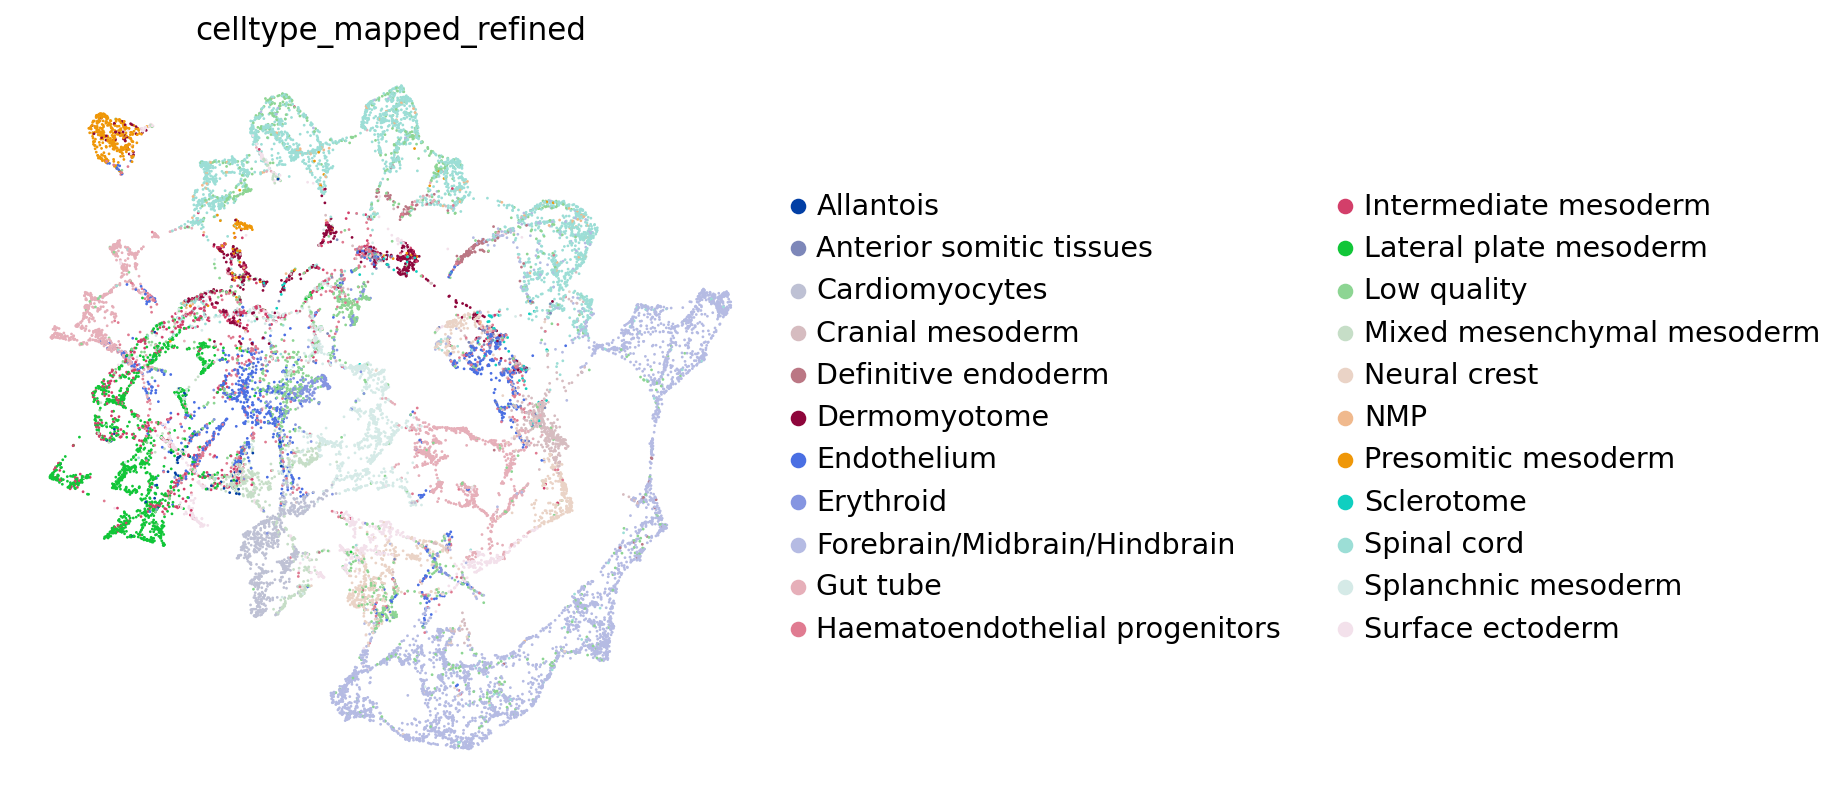

In [22]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_fc_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_fc_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_fc_gps_{current_time}.png")

## 4. Autotalker Model with Cell-Cell-Interaction (CCI) Gene Programs

### 4.1 NicheNet CCI Gene Programs

#### 4.1.1 Create NicheNet CCI Gene Program Mask

In [ ]:
nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
    keep_target_ratio=0.1,
    load_from_disk=False,
    save_to_disk=True,
    file_path=nichenet_ligand_target_mx_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=nichenet_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_nichenet_gps_targets",
    gp_sources_varm_key="autotalker_nichenet_gps_sources",
    gp_names_uns_key="autotalker_nichenet_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_nichenet_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_nichenet_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_nichenet_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_nichenet_gps_sources'].sum()}.")

In [ ]:
nichenet_gps_targets_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_targets"].T, dtype=torch.float32)
nichenet_gps_sources_mask = torch.tensor(adata.varm["autotalker_nichenet_gps_sources"].T, dtype=torch.float32)
nichenet_gps_mask = torch.cat((nichenet_gps_targets_mask, nichenet_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {nichenet_gps_mask.shape}.")
nichenet_gps_n_hidden_encoder = int(nichenet_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {nichenet_gps_n_hidden_encoder}.")

#### 4.1.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_nichenet_gps_targets",
                   gp_sources_mask_key="autotalker_nichenet_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=nichenet_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_nichenet_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

#### 4.1.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_nichenet_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_nichenet_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_nichenet_gps_{current_time}.png")

### 4.2 OmniPath CCI Gene Programs

#### 4.2.1 Create OmniPath CCI Gene Program Mask

In [ ]:
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    min_curation_effort=0,
    load_from_disk=False,
    save_to_disk=True,
    file_path=omnipath_lr_interactions_file_path)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=omnipath_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_omnipath_gps_targets",
    gp_sources_varm_key="autotalker_omnipath_gps_sources",
    gp_names_uns_key="autotalker_omnipath_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_omnipath_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_omnipath_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_omnipath_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_omnipath_gps_sources'].sum()}.")

In [ ]:
omnipath_gps_targets_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_targets"].T, dtype=torch.float32)
omnipath_gps_sources_mask = torch.tensor(adata.varm["autotalker_omnipath_gps_sources"].T, dtype=torch.float32)
omnipath_gps_mask = torch.cat((omnipath_gps_targets_mask, omnipath_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {omnipath_gps_mask.shape}.")
omnipath_gps_n_hidden_encoder = int(omnipath_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {omnipath_gps_n_hidden_encoder}.")

#### 4.2.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_omnipath_gps_targets",
                   gp_sources_mask_key="autotalker_omnipath_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=omnipath_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_omnipath_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=edge_batch_size,
            mlflow_experiment_id=experiment.experiment_id)

#### 4.2.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_omnipath_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_omnipath_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_omnipath_gps_{current_time}.png")

### 4.3 NicheNet & OmniPath CCI Gene Programs Combined

#### 4.3.1 Create Combined Gene Program Mask

In [ ]:
combined_gp_dict = dict(nichenet_gp_dict)
combined_gp_dict.update(omnipath_gp_dict)

In [ ]:
add_gps_from_gp_dict_to_adata(
    adata=adata,
    gp_dict=combined_gp_dict,
    genes_uppercase=True,
    gp_targets_varm_key="autotalker_combined_gps_targets",
    gp_sources_varm_key="autotalker_combined_gps_sources",
    gp_names_uns_key="autotalker_combined_gps_names",
    min_genes_per_gp=0,
    max_genes_per_gp=None)

In [ ]:
print(f"Number of gene programs: {len(adata.uns['autotalker_combined_gps_names'])}.")
print(f"Example gene programs: {adata.uns['autotalker_combined_gps_names'][:5]}.")
print(f"Number of gene program target genes: {adata.varm['autotalker_combined_gps_targets'].sum()}.")
print(f"Number of gene program source genes: {adata.varm['autotalker_combined_gps_sources'].sum()}.")

In [ ]:
combined_gps_targets_mask = torch.tensor(adata.varm["autotalker_combined_gps_targets"].T, dtype=torch.float32)
combined_gps_sources_mask = torch.tensor(adata.varm["autotalker_combined_gps_sources"].T, dtype=torch.float32)
combined_gps_mask = torch.cat((combined_gps_targets_mask, combined_gps_sources_mask), dim=1)
print(f"Gene program mask shape (gene programs x nodes): {combined_gps_mask.shape}.")
combined_gps_n_hidden_encoder = int(combined_gps_mask.shape[0] / 2)
print(f"Number of hidden layers in the encoder: {combined_gps_n_hidden_encoder}.")

#### 4.3.2 Initialize, Train & Save Model

In [ ]:
model = Autotalker(adata,
                   counts_layer_key="counts",
                   adj_key="spatial_connectivities",
                   gp_targets_mask_key="autotalker_combined_gps_targets",
                   gp_sources_mask_key="autotalker_combined_gps_sources",
                   include_edge_recon_loss=True,
                   include_gene_expr_recon_loss=True,
                   log_variational=True,
                   node_label_method=node_label_method,
                   n_hidden_encoder=combined_gps_n_hidden_encoder,
                   dropout_rate_encoder=0.,
                   dropout_rate_graph_decoder=0.,
                   gp_targets_mask=None,
                   gp_sources_mask=None)

In [ ]:
experiment = mlflow.set_experiment("autotalker_combined_gps")
mlflow.log_param("dataset", dataset)

model.train(n_epochs=30,
            lr=0.01,
            weight_decay=0,
            edge_val_ratio=0.1,
            edge_test_ratio=0.05,
            node_val_ratio=0.1,
            edge_batch_size=32,
            grad_clip_value=5,
            mlflow_experiment_id=None)

#### 4.3.3 Visualize Latent Gene Programs with scanpy

In [ ]:
# adata used during model training
latent = model.get_latent_representation()
# New adata
latent_new_data = model.get_latent_representation(adata)
adata.obsm["latent_autotalker_combined_gps"] = latent_new_data

now = datetime.now()
current_time = now.strftime("%d%m%Y_%H%M%S")

sc.set_figure_params(figsize=(6, 6))

# Use autotalker latent space for UMAP generation
sc.pp.neighbors(adata, use_rep="latent_autotalker_combined_gps")
sc.tl.umap(adata, min_dist=0.3)
sc.pl.umap(adata, color=[cell_type_key], frameon=False, save=f"_latent_autotalker_combined_gps_{current_time}.png")

The model can maintain the edge reconstruction performance while tweaking the latent space for better gene expression reconstruction.

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]

In [ ]:
gene_programs = adata.uns["autotalker_combined_gps_names"]
selected_gene_programs = ["CSF1_ligand_targetgenes_GP", "IL34_ligand_targetgenes_GP"]
selected_gene_programs_idx = [gene_programs.index(gene_program) for gene_program in selected_gene_programs]

In [ ]:
latent_selected_gps = latent[:, selected_gene_programs_idx]

In [ ]:
adata.obs["CSF1_ligand_targetgenes_GP"] = latent_selected_gps[:, 0]
adata.obs["IL34_ligand_targetgenes_GP"] = latent_selected_gps[:, 1]

In [ ]:
sc.pl.umap(adata, color="CSF1_ligand_targetgenes_GP", frameon=False, wspace=0.6)

In [ ]:
sc.pl.scatter(adata, x="CSF1_ligand_targetgenes_GP", y="IL34_ligand_targetgenes_GP", color=cell_type_key, size=10)

### 5. Benchmarking

#### Cell-type Affinity Distance (CAD)

In [71]:
for i in np.linspace(0.1, 1.0, 10, dtype=np.float32):
    print(i)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


In [48]:
avg_ctad = compute_avg_ctad_metric(adata=adata,
                                   cell_type_key="celltype_mapped_refined",
                                   spatial_key="spatial",
                                   latent_rep_key="latent_autotalker_fc_gps",
                                   seed=random_state)

In [50]:
avg_ctad

299.341814403882

#### Leiden Normalized Mutual Info (LNMI)

In [83]:
min_lnmi = compute_min_lnmi_metric(adata=adata,
                                   spatial_key="spatial",
                                   latent_rep_key="latent_autotalker_fc_gps",
                                   seed=random_state)

In [84]:
min_lnmi

0.42374523716958956

In [85]:
adata

AnnData object with n_obs × n_vars = 19416 × 351
    obs: 'Area', 'celltype_mapped_refined', 'leiden_0.1', 'leiden_0.2', 'leiden_0.30000000000000004', 'leiden_0.4', 'leiden_0.5', 'leiden_0.6', 'leiden_0.7000000000000001', 'leiden_0.8', 'leiden_0.9', 'leiden_1.0', 'lnmi_spatial_0.10000000149011612', 'lnmi_spatial_0.20000000298023224', 'lnmi_spatial_0.30000001192092896', 'lnmi_spatial_0.4000000059604645', 'lnmi_spatial_0.5', 'lnmi_spatial_0.6000000238418579', 'lnmi_spatial_0.699999988079071', 'lnmi_spatial_0.800000011920929', 'lnmi_spatial_0.8999999761581421', 'lnmi_spatial_1.0', 'lnmi_latent_0.10000000149011612', 'lnmi_latent_0.20000000298023224', 'lnmi_latent_0.30000001192092896', 'lnmi_latent_0.4000000059604645', 'lnmi_latent_0.5', 'lnmi_latent_0.6000000238418579', 'lnmi_latent_0.699999988079071', 'lnmi_latent_0.800000011920929', 'lnmi_latent_0.8999999761581421', 'lnmi_latent_1.0', 'lnmi_spatial_0.1', 'lnmi_spatial_0.2', 'lnmi_spatial_0.3', 'lnmi_spatial_0.4', 'lnmi_spatial_0.6', 'lnm

#### Cell-type Local Inverse Simpson's Index (CLISI)

In [209]:
sc.pp.neighbors(adata, n_neighbors=6, use_rep="latent_autotalker_fc_gps", random_state=random_state, key_added="clisi_latent")

In [291]:
from autotalker.benchmarking import clisi

[autoreload of autotalker.benchmarking failed: Traceback (most recent call last):
  File "/home/cartalop/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 257, in check
    superreload(m, reload, self.old_objects)
  File "/home/cartalop/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 455, in superreload
    module = reload(module)
  File "/home/cartalop/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 850, in exec_module
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/home/cartalop/sebastianbirk/autotalker-dev/autotalker/benchmarking/__init__.py", line 1, in <module>
    from .cad import compute_avg_ctad_metric, compute_cell_type_affinity_distance
ImportError: cannot import name 'compute_avg_ctad_metric' from 'autotalker.benc

In [135]:
    for cell_id in np.arange(np.min(dist_mat[0]), np.max(dist_mat[0]) + 1):
        get_idx = dist_mat[0] == cell_id
        num_idx = get_idx.sum()
        # in case that get_idx contains more than n_nn neighbours, cut away the outlying ones
        fin_idx = np.min([num_idx, n_neighbors])
        neighbor_index[cell_id, :fin_idx] = dist_mat[1][get_idx][
            np.argsort(dist_mat[2][get_idx])
        ][:fin_idx]
        neighbor_dist[cell_id, :fin_idx] = np.sort(dist_mat[2][get_idx])[:fin_idx]
        if num_idx < n_neighbors:
            index_out.append(cell_id)

In [176]:
scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[1][:20]

array([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 4, 4],
      dtype=int32)

In [181]:
(scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[2] == 1).sum()

25494

In [303]:
    # Create neighbor graph from spatial coordinates
    sq.gr.spatial_neighbors(adata,
                            spatial_key="spatial",
                            coord_type="generic",
                            n_neighs=6,
                            key_added="clisi_spatial")

In [328]:
    # Create neighbor graph from spatial coordinates
    sq.gr.spatial_neighbors(adata,
                            spatial_key="latent_autotalker_fc_gps",
                            coord_type="generic",
                            n_neighs=6,
                            key_added="clisi_spatial")

SyntaxError: invalid syntax (2653375536.py, line 7)

In [330]:
len(scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0])

96645

In [324]:
len(scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1])

96645

In [327]:
scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])

(array([  396,   407,   966, ..., 18837, 18877, 18900], dtype=int32),
 array([    0,     0,     0, ..., 19415, 19415, 19415], dtype=int32),
 array([1.        , 0.99999994, 0.7337197 , ..., 0.25963935, 1.        ,
        0.51553386], dtype=float32))

In [313]:
_, counts = np.unique(scipy.sparse.find(adata.obsp["clisi_spatial_distances"])[1], return_counts=True)

In [420]:
sc.pp.neighbors(adata,
                n_neighbors=neighborhood_graph_n_neighs,
                use_rep="latent_autotalker_fc_gps",
                random_state=42,
                knn=True,
                key_added="clisi_latent")

In [421]:
len(scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0])

96645

In [422]:
len(scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[0])

122308

In [343]:
adata.X.shape[0] * 6b

116496

In [56]:
from autotalker.benchmarking.utils import _compute_knn_graph
from autotalker.benchmarking.clisi import _compute_cell_level_clisi_from_adata
from autotalker.benchmarking import compute_cell_level_log_clisi_ratios

In [57]:
adata_clisi = _compute_cell_level_clisi_from_adata(adata, knn_graph_feature_key="spatial", knn_graph_n_neighbors=18, cell_type_key="celltype_mapped_refined")

In [58]:
clisi = compute_cell_level_log_clisi_ratios(adata)

In [59]:
clisi

,log_clisi_ratio
0,-0.237776
1,-0.284259
2,-0.586533
3,-0.134311
4,0.063090
...,...
19411,0.442654
19412,0.125561
19413,-0.277797
19414,0.090080


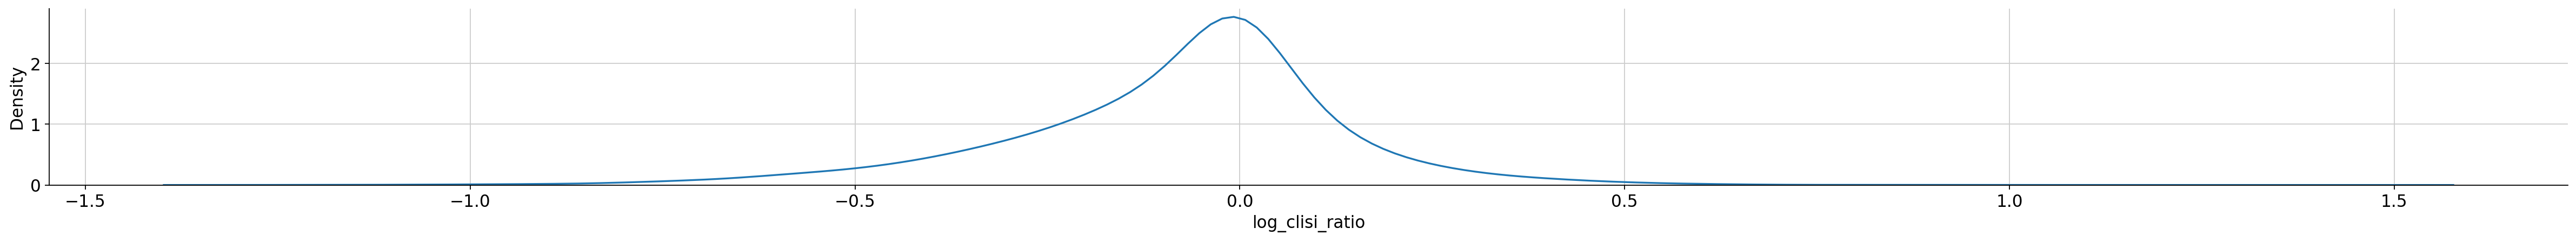

In [60]:
import seaborn as sns
sns.displot(clisi, x="log_clisi_ratio", kind="kde", bw_adjust=2, height=3, aspect=10)

In [38]:
adata_clisi

array([2.23094281, 1.25562298, 1.5159955 , ..., 1.79026323, 2.31135483,
       2.45521135])

In [695]:
knn_indices, knn_distances = _compute_knn_graph(adata, "latent_autotalker_fc_gps", 6)

In [23]:
clisi = _compute_clisi(adata, "latent_autotalker_fc_gps")

TypeError: _compute_clisi() missing 2 required positional arguments: 'knn_graph_n_neighbors' and 'cell_type_key'

In [24]:
clisi_metric = compute_clisi_metric(adata)

In [25]:
clisi_metric

,0
0,-0.090493
1,-0.040771
2,-0.499578
3,-0.006486
4,0.095080
...,...
19411,0.112024
19412,0.088562
19413,-0.143782
19414,-0.062638


In [687]:
len(clisi)

19416

In [656]:
paired_distances = pairwise_distances(X, metric=metric)

In [668]:
sample_range = np.arange(paired_distances.shape[0])[:, None]

In [671]:
indices = np.argpartition(paired_distances, n_neighbors - 1, axis=1)[:, :n_neighbors]

In [672]:
indices

array([[  396,   966,     0,  4930,   407,  4698],
       [    1,    42,  1241,  1189,   620,   628],
       [    2,   851, 15810,   738, 15796,   721],
       ...,
       [18082, 18142, 19413, 19405, 17898, 18265],
       [ 6622, 19414, 12580,  6547, 14788, 19412],
       [19415, 18877, 18770, 18749, 18900, 18837]])

In [665]:
indices.shape

(19416, 19416)

In [670]:
indices = indices[sample_range, np.argsort(paired_distances[sample_range, indices])]

In [ ]:
indices.shape

In [ ]:
    sample_range = np.arange(paired_distances.shape[0])[:, None]
    indices = np.argpartition(D, n_neighbors - 1, axis=1)[:, :n_neighbors]
    indices = indices[sample_range, np.argsort(D[sample_range, indices])]
    distances = D[sample_range, indices]
    return indices, distances

In [688]:
knn_indices

array([[    0,   396,   407,   966,  4930,  4698],
       [    1,    42,  1241,  1189,   620,   628],
       [    2,   851, 15810,   738, 15796,   721],
       ...,
       [19413, 19405, 18082, 18142, 17898, 18265],
       [19414,  6622, 12580,  6547, 14788, 19412],
       [19415, 18877, 18770, 18749, 18900, 18837]])

In [690]:
perplexity = np.floor(knn_indices.shape[1] / 3)

In [693]:
adata.obs[cell_type_key].cat.codes.values

array([13, 12,  7, ..., 19, 10, 19], dtype=int8)

In [621]:
rows[:20]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3])

In [595]:
cols[:20]

array([    0,   396,   407,   966,  4930,  4698,     1,    42,  1241,
        1189,   620,   628,     2,   851, 15810,   738, 15796,   721,
           3,   531])

In [625]:
cols[rows == 0]

array([   0,  396,  407,  966, 4930, 4698])

In [628]:
vals[rows == 0]

array([0.        , 0.00015165, 0.00166404, 0.00223555, 0.00344133,
       0.00404351])

In [629]:
cols[rows == 0]

array([   0,  396,  407,  966, 4930, 4698])

In [630]:
vals[rows == 407]

array([0.        , 0.00166404, 0.00181569, 0.00237947, 0.00289932,
       0.00289932])

In [631]:
cols[rows == 407]

array([ 407,    0,  396, 4698, 4639, 4656])

In [596]:
vals[:20]

array([0.00000000e+00, 1.51646527e-04, 1.66404445e-03, 2.23555323e-03,
       3.44133261e-03, 4.04351298e-03, 0.00000000e+00, 0.00000000e+00,
       6.02840482e-05, 6.02842847e-05, 6.55392185e-04, 1.41199981e-03,
       0.00000000e+00, 3.18516418e-02, 3.21019590e-02, 3.38013247e-02,
       3.47904637e-02, 3.54375765e-02, 0.00000000e+00, 1.14077376e-02])

In [633]:
_distances.toarray()[0, 4698]

0.004043512977659702

In [618]:
_distances.toarray()[0, 407]

0.0016640444518998265

In [611]:
_distances.toarray()[4698, 0]

0.0

In [637]:
scipy.sparse.find(_distances)[1][scipy.sparse.find(_distances)[0] == 0]

array([ 396,  407,  966, 4698, 4930], dtype=int32)

In [638]:
scipy.sparse.find(_distances)[2][scipy.sparse.find(_distances)[0] == 0]

array([0.00015165, 0.00166404, 0.00223555, 0.00404351, 0.00344133])

In [605]:
scipy.sparse.find(_distances)[1][:20]

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 5, 5],
      dtype=int32)

In [580]:
knn_indices[4698]

array([4698, 4639, 4656,  407,  431, 4612], dtype=int32)

In [573]:
knn_distances

array([[0.00000000e+00, 1.51646527e-04, 1.66404445e-03, 2.23555323e-03,
        3.44133261e-03, 4.04351298e-03],
       [0.00000000e+00, 0.00000000e+00, 6.02840482e-05, 6.02842847e-05,
        6.55392185e-04, 1.41199981e-03],
       [0.00000000e+00, 3.18516418e-02, 3.21019590e-02, 3.38013247e-02,
        3.47904637e-02, 3.54375765e-02],
       ...,
       [0.00000000e+00, 5.20283207e-02, 5.56940287e-02, 5.72786368e-02,
        5.91526143e-02, 6.01356365e-02],
       [0.00000000e+00, 7.60834431e-03, 1.42900338e-02, 1.64910331e-02,
        1.66748855e-02, 1.83293968e-02],
       [0.00000000e+00, 6.73982874e-02, 1.16180345e-01, 1.22433059e-01,
        1.38728067e-01, 1.62734121e-01]], dtype=float32)

In [570]:
(knn_distances == 0).sum() + len(scipy.sparse.find(_distances)[1])

116496

In [563]:
len(scipy.sparse.find(_distances)[1])

96645

In [572]:
scipy.sparse.find(_distances)[0][scipy.sparse.find(_distances)[1] == 0]

array([ 396,  407,  966, 4841, 4930], dtype=int32)

In [502]:
len(scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0])

96645

In [464]:
len(scipy.sparse.find(distances)[0])

116490

In [465]:
adata.obsp["clisi_latent_distances"]

<19416x19416 sparse matrix of type '<class 'numpy.float64'>'
	with 96645 stored elements in Compressed Sparse Row format>

In [332]:
dist_mat = scipy.sparse.find(adata.obsp["clisi_latent_distances"])
dist_mat

(array([  396,   407,   966, ..., 18770, 18877, 18900], dtype=int32),
 array([    0,     0,     0, ..., 19415, 19415, 19415], dtype=int32),
 array([0.00015165, 0.00166404, 0.00223555, ..., 0.11618035, 0.06739829,
        0.13872807]))

In [345]:
dist_mat = scipy.sparse.find(adata.obsp["clisi_latent_distances"])
# initialise index and fill it with NaN values
nn_index = np.empty(shape=(adata.obsp["clisi_latent_distances"].shape[0], neighborhood_graph_n_neighs))
nn_index[:] = np.nan
nn_dists = np.empty(shape=(adata.obsp["clisi_latent_distances"].shape[0], neighborhood_graph_n_neighs))
nn_dists[:] = np.nan
index_out = []
for cell_id in np.arange(np.min(dist_mat[0]), np.max(dist_mat[0]) + 1):
    get_idx = dist_mat[0] == cell_id
    num_idx = get_idx.sum()
    # in case that get_idx contains more than n_nn neighbours, cut away the outlying ones
    fin_idx = np.min([num_idx, n_nn])
    nn_index[cell_id, :fin_idx] = dist_mat[1][get_idx][
        np.argsort(dist_mat[2][get_idx])
    ][:fin_idx]
    nn_dists[cell_id, :fin_idx] = np.sort(dist_mat[2][get_idx])[:fin_idx]
    if num_idx < n_nn:
        index_out.append(cell_id)
out_cells = len(index_out)
if out_cells > 0:
    if verbose:
        print(f"{out_cells} had less than {n_nn} neighbors.")

19416 had less than 6 neighbors.


In [349]:
np.sort(scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0])[:20]

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 4],
      dtype=int32)

In [350]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1][:20]

array([0, 0, 0, 0, 0, 1, 1, 1, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 5, 5],
      dtype=int32)

In [370]:
np.sort(scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0])[:100]

array([ 0,  0,  0,  0,  0,  1,  1,  1,  1,  2,  2,  2,  2,  2,  3,  3,  3,
        3,  3,  4,  4,  4,  4,  4,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,
        7,  7,  7,  7,  7,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9, 10, 10,
       10, 10, 10, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 13, 13, 13, 13,
       13, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 17,
       17, 17, 17, 17, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 20],
      dtype=int32)

In [372]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1][:100]

array([ 0,  0,  0,  0,  0,  1,  1,  1,  2,  2,  2,  2,  2,  4,  4,  4,  4,
        4,  5,  5,  5,  5,  5,  5,  5,  5,  6,  6,  6,  6,  6,  6,  7,  7,
        7,  7,  8,  8,  8,  8,  8,  8,  9, 10, 10, 10, 10, 10, 11, 11, 11,
       11, 11, 11, 12, 12, 13, 13, 13, 13, 13, 13, 14, 14, 14, 14, 14, 14,
       14, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17,
       18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 20, 20],
      dtype=int32)

In [393]:
scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[0][:6]  # 4698

array([ 396,  407,  966, 4698, 4841, 4930], dtype=int32)

In [394]:
scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[1][:6]

array([0, 0, 0, 0, 0, 0], dtype=int32)

In [408]:
scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[0][scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[1] == 4698]

array([   0,  353,  396,  407,  431,  512, 4612, 4639, 4656], dtype=int32)

In [392]:
scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[2][:6]

array([1.        , 0.99999994, 0.7337197 , 0.24139914, 0.19279245,
       0.5207156 ], dtype=float32)

In [407]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0][:5]

array([ 396,  407,  966, 4841, 4930], dtype=int32)

In [410]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1][:5]

array([0, 0, 0, 0, 0], dtype=int32)

In [400]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[2][:5]

array([0.00015165, 0.00166404, 0.00223555, 0.00740419, 0.00344133])

In [413]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0][scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1] == 4930]

array([   0,  396,  966, 4841, 4998], dtype=int32)

In [414]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[2][scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1] == 4930]

array([0.00344133, 0.00328991, 0.00121488, 0.00646683, 0.00184204])

In [402]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0][scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1] == 4841]

array([ 440, 4995, 5097], dtype=int32)

In [406]:
scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0][scipy.sparse.find(adata.obsp["clisi_latent_distances"])[1] == 0]

array([ 396,  407,  966, 4841, 4930], dtype=int32)

In [316]:
scipy.sparse.find(adata.obsp["clisi_spatial_distances"])[0][scipy.sparse.find(adata.obsp["clisi_spatial_distances"])[1] == 61]

array([   83,   124,   183, 13661, 13818], dtype=int32)

In [311]:
scipy.sparse.find(adata.obsp["clisi_spatial_distances"])[1][:20]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3],
      dtype=int32)

In [252]:
n_nn = 6
verbose = True

In [260]:
    # initialise index and fill it with NaN values
    nn_index = np.empty(shape=(adata.obsp["clisi_spatial_distances"].shape[0], n_nn))
    nn_index[:] = np.NaN
    nn_dists = np.empty(shape=(adata.obsp["clisi_spatial_distances"].shape[0], n_nn))
    nn_dists[:] = np.NaN
    index_out = []
    for cell_id in np.arange(np.min(dist_mat[0]), np.max(dist_mat[0]) + 1):
        get_idx = dist_mat[0] == cell_id
        num_idx = get_idx.sum()
        # in case that get_idx contains more than n_nn neighbours, cut away the outlying ones
        fin_idx = np.min([num_idx, n_nn])
        nn_index[cell_id, :fin_idx] = dist_mat[1][get_idx][
            np.argsort(dist_mat[2][get_idx])
        ][:fin_idx]
        nn_dists[cell_id, :fin_idx] = np.sort(dist_mat[2][get_idx])[:fin_idx]
        if num_idx < n_nn:
            index_out.append(cell_id)

    out_cells = len(index_out)

    if out_cells > 0:
        if verbose:
            print(f"{out_cells} had less than {n_nn} neighbors.")

37 had less than 6 neighbors.


In [238]:
sparse_dist_mat = scipy.sparse.find(adata.obsp["clisi_spatial_distances"])

In [248]:
len(sparse_dist_mat[2])

116496

In [256]:
sparse_dist_mat[0]

116496

In [281]:
    # initialise index and fill it with NaN values
    nn_index = np.empty(shape=(adata.obsp["clisi_spatial_distances"].shape[0], n_nn))
    nn_index[:] = np.NaN
    nn_dists = np.empty(shape=(adata.obsp["clisi_spatial_distances"].shape[0], n_nn))
    nn_dists[:] = np.NaN
    index_out = []
    for cell_id in np.arange(np.min(sparse_dist_mat[1]), np.max(sparse_dist_mat[1]) + 1):
        get_idx = sparse_dist_mat[1] == cell_id
        num_idx = get_idx.sum()
 # in case that get_idx contains more than n_nn neighbours, cut away the outlying ones
        fin_idx = np.min([num_idx, n_neighbors])
        neighbor_index[cell_id, :fin_idx] = sparse_dist_mat[1][get_idx][
            np.argsort(sparse_dist_mat[2][get_idx])
        ][:fin_idx]
        neighbor_dist[cell_id, :fin_idx] = np.sort(sparse_dist_mat[2][get_idx])[:fin_idx]
        if num_idx < n_neighbors:
            index_out.append(cell_id)

ValueError: could not broadcast input array from shape (6,) into shape (5,)

In [288]:
neighborhood_graph_n_neighs = 6

In [289]:
neighbor_dist_mat = sparse_dist_mat[2].reshape(sparse_dist_mat[1][-1] + 1,
                                               neighborhood_graph_n_neighs)

In [290]:
neighbor_dist_mat

array([[0.03789307, 0.03150929, 0.02430351, 0.03234643, 0.0458938 ,
        0.0488195 ],
       [0.00500248, 0.01778825, 0.026575  , 0.01957005, 0.03142595,
        0.03530723],
       [0.03772477, 0.0449059 , 0.04350672, 0.01334945, 0.03773965,
        0.03763959],
       ...,
       [0.01975191, 0.04841171, 0.04466857, 0.041317  , 0.03810268,
        0.04611072],
       [0.04518513, 0.03993335, 0.0167354 , 0.03942626, 0.04504688,
        0.04240767],
       [0.03565959, 0.04365348, 0.01890662, 0.00931617, 0.03987882,
        0.0366897 ]])

In [284]:
sparse_dist_mat[0].reshape(sparse_dist_mat[1][-1] + 1, n_neighbors)

array([[  283,   303,   686,   707,  1230,  1265],
       [   42,   104,   122,  1240,  1263,  1268],
       [   12,    29,    31,   732,   733,   738],
       ...,
       [19349, 19361, 19367, 19370, 19405, 19411],
       [18747, 18797, 18841, 18843, 19395, 19412],
       [18749, 18760, 18828, 18837, 18857, 18877]], dtype=int32)

In [301]:
from autotalker.benchmarking import compute_clisi_metric

In [302]:
clisi = compute_clisi_metric(adata)

ValueError: cannot reshape array of size 116074 into shape (19416,6)

In [ ]:
clisi

In [243]:
nn_index.shape

(19416, 6)

In [225]:
nn_dists

array([[1.51646527e-04, 1.66404445e-03, 2.23555323e-03, 3.44133261e-03,
        4.04351298e-03, 4.55865311e-03],
       [6.02840482e-05, 6.02842847e-05, 6.55392185e-04, 1.41199981e-03,
        2.21170881e-03, 2.21170881e-03],
       [3.18516418e-02, 3.21019590e-02, 3.38013247e-02, 3.47904637e-02,
        3.54375765e-02, 4.19068933e-02],
       ...,
       [5.20283207e-02, 5.56940287e-02, 5.72786368e-02, 5.91526143e-02,
        6.01356365e-02, 6.12197071e-02],
       [7.60834431e-03, 1.42900338e-02, 1.64910331e-02, 1.66748855e-02,
        1.83293968e-02, 2.17878278e-02],
       [6.73982874e-02, 1.16180345e-01, 1.22433059e-01, 1.38728067e-01,
        1.62734121e-01, 1.71226561e-01]])

In [226]:
nn_index

array([[  396.,   407.,   966.,  4930.,  4698.,  4998.],
       [ 1241.,  1189.,   620.,   628.,  4608.,  5376.],
       [  851., 15810.,   738., 15796.,   721.,   733.],
       ...,
       [19405., 18082., 18142., 17898., 18265., 18071.],
       [ 6622., 12580.,  6547., 14788., 19412.,    68.],
       [18877., 18770., 18749., 18900., 18837., 12887.]])

In [204]:
scipy.sparse.find(adata.obsp["clisi_spatial_connectivities"])[0][:20]

array([  396,   407,   966,  4698,  4930,  4998,    42,   620,   628,
        1189,  1241,  4608,   721,   733,   738,   851, 15796, 15810,
         531,  1108], dtype=int32)

In [205]:
scipy.sparse.find(adata.obsp["clisi_spatial_connectivities"])[1][:20]

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3],
      dtype=int32)

In [207]:
len(scipy.sparse.find(adata.obsp["clisi_spatial_distances"])[2])

116074

In [191]:
adata.obsp["clisi_spatial_connectivities"].toarray().sum()

116496.0

In [166]:
len(scipy.sparse.find(adata.obsp["clisi_latent_connectivities"])[0])

99056

In [167]:
len(scipy.sparse.find(adata.obsp["clisi_latent_distances"])[0])

77266

In [127]:
dist_mat[2][get_idx]

array([3.15173576e-03, 3.77333513e-03, 2.84005003e-03, 6.55392185e-04,
       1.41199981e-03, 6.02842847e-05, 2.42655864e-03, 3.84196942e-03,
       2.78988481e-03, 6.02840482e-05, 2.21170881e-03, 5.19117806e-03,
       2.21170881e-03])

In [26]:
adata.obsm["spatial"]

array([[ 0.72926073, -2.82174578],
       [ 0.70843688, -2.70712631],
       [ 0.96172602, -2.94395082],
       ...,
       [-1.51395795,  2.62545878],
       [-1.38935352,  3.13495082],
       [-1.39499228,  2.58127179]])

#### Edge Reconstruction AUROC (ERAUC)

### 6. Comparison SCVI Model

In [ ]:
import scvi
import scanpy as sc
import matplotlib.pyplot as plt

sc.set_figure_params(figsize=(6, 6))

# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

In [ ]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [ ]:
scvi.model.SCVI.setup_anndata(
    adata,
    layer="counts"
)

In [ ]:
model = scvi.model.SCVI(adata)

In [ ]:
model

In [ ]:
model.train()

In [ ]:
latent_scvi = model.get_latent_representation()

In [ ]:
adata.obsm["X_scVI"] = latent_scvi

In [ ]:
# run PCA then generate UMAP plots
sc.tl.pca(adata)
sc.pp.neighbors(adata, use_rep="X_scVI")
sc.tl.umap(adata, min_dist=0.3)

In [ ]:
sc.pl.umap(adata, color=["celltype_mapped_refined"], frameon=False,)